In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn import linear_model
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree # for tree.plot_tree()
from sklearn.tree import export_text # for export_text()
from matplotlib import pyplot as plt

In [2]:
# read data and data clean
Train = pd.read_csv('train.csv',index_col=0)
Test = pd.read_csv('test.csv',index_col=0)
Train = Train.dropna()
Test = Test.dropna()
# data transformation
def transformData (feature):
    df_ = pd.get_dummies(feature, drop_first=False)
    df_name = df_.columns[0]
    return df_.drop([df_name], axis=1)
X_train = Train.drop(['id','Gender','Customer Type','Type of Travel','Class','satisfaction'], axis=1)
X_test = Test.drop(['id','Gender','Customer Type','Type of Travel','Class','satisfaction'], axis=1)
Transformation_ = []
satisfaction_ = []
for i in [Train,Test]:
    Gender = transformData (i['Gender'])
    Customer_Type = transformData (i['Customer Type'])
    Type_of_Travel = transformData (i['Type of Travel'])
    Class = pd.get_dummies(i['Class'], drop_first=False)
    satisfaction = transformData (i['satisfaction'])
    Transformation  = [Gender,Customer_Type,Type_of_Travel,Class]
    Transformation_.append(Transformation)
    satisfaction_.append(satisfaction)
for i in Transformation_[0]:
    X_train = X_train.join(i)
for i in Transformation_[1]:
    X_test = X_test.join(i)
y_train = satisfaction_[0]
y_test = satisfaction_[1]
feature_names=list(X_train.columns)
y_train=y_train.to_numpy()
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
y_test=y_test.to_numpy()

In [3]:
#logistic model
model = linear_model.LogisticRegression(C=1, penalty='l1', solver='liblinear')
model.fit(X_train, y_train.T[0].T)
model.score(X_test, y_test.T[0].T)

0.8717800177654192

best depth=16


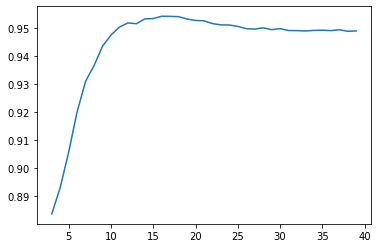

In [4]:
# find best max_depth
depth=[]
score_lst=[]
for i in range(3,40):
    depth.append(i)
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0)
    clf.fit(X_train, y_train)
    score=clf.score(X_test, y_test)
    score_lst.append(score)
plt.plot(depth,score_lst)
Z = [depth for _,depth in sorted(zip(score_lst,depth))]
print(f'best depth={Z[-1]}')


In [5]:
#grid-search find best hyperparametre 
parameters = {'criterion':("gini","entropy","log_loss"), 'max_depth':[16]}
dt = DecisionTreeClassifier()
clf_max = GridSearchCV(dt, parameters)
clf_max.fit(X_train, y_train)
print(f'clf.best_score_={clf_max.best_score_:.3}, ' +
      f'clf.best_params_={clf_max.best_params_}')

clf.best_score_=0.953, clf.best_params_={'criterion': 'log_loss', 'max_depth': 16}


In [6]:
# decision tree model
clf = DecisionTreeClassifier(criterion='entropy', max_depth=16, random_state=0)
clf.fit(X_train, y_train)
print(export_text(clf, feature_names=feature_names))
print(f'Accuracy on training data is clf.score(X, y)={clf.score(X_test, y_test)}.')

|--- Online boarding <= 3.50
|   |--- Inflight wifi service <= 3.50
|   |   |--- Inflight wifi service <= 0.50
|   |   |   |--- Inflight entertainment <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Inflight entertainment >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Inflight wifi service >  0.50
|   |   |   |--- Business <= 0.50
|   |   |   |   |--- Personal Travel <= 0.50
|   |   |   |   |   |--- disloyal Customer <= 0.50
|   |   |   |   |   |   |--- Checkin service <= 4.50
|   |   |   |   |   |   |   |--- Baggage handling <= 4.50
|   |   |   |   |   |   |   |   |--- Inflight service <= 4.50
|   |   |   |   |   |   |   |   |   |--- Age <= 33.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- Age >  33.50
|   |   |   |   |   |   |   |   |   |   |--- Inflight wifi service <= 1.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- Inflight wifi service >  1.5

Text(0.5, 0, 'Random Forest Feature Importance')

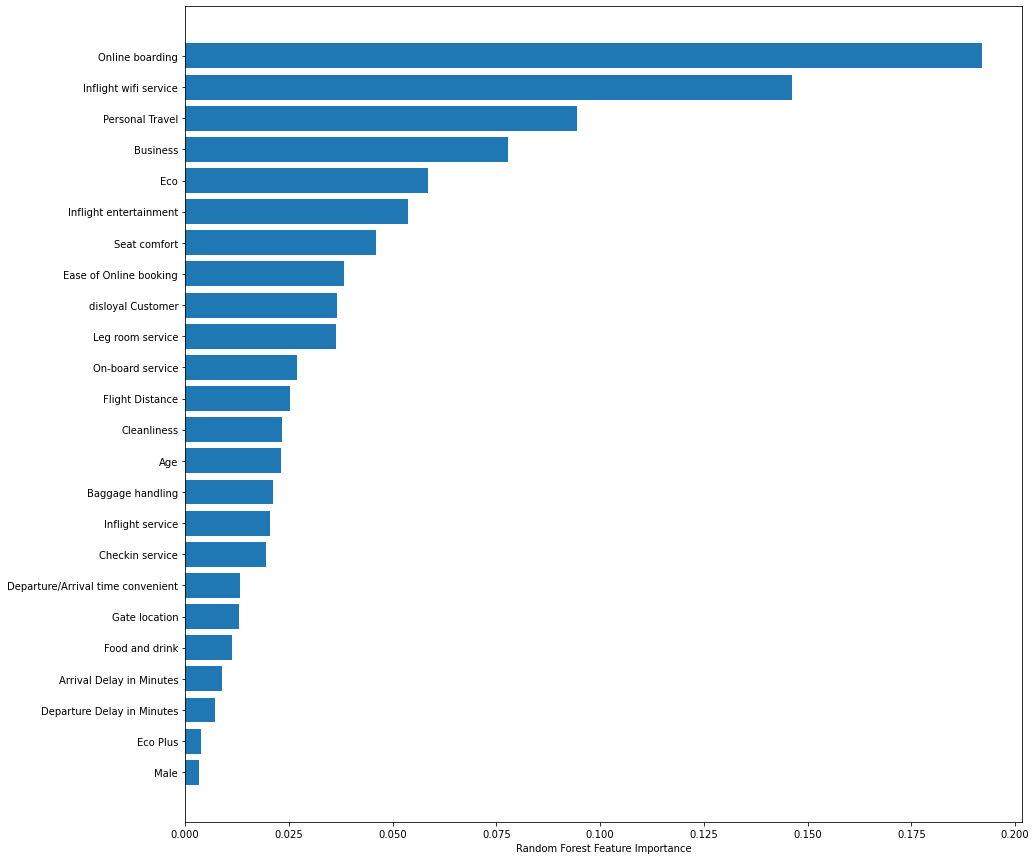

In [7]:
#find importances of features
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
forests=RandomForestClassifier(max_depth=16,random_state=0)
forests.fit(X_train,y_train.T[0].T)
importance=forests.feature_importances_
sorted_feature = [feature_names for _,feature_names in sorted(zip(importance,feature_names),reverse=False)]
plt.figure(figsize=(15,15)) 
plt.barh(sorted_feature,sorted(importance,reverse=False))
plt.xlabel("Random Forest Feature Importance")

In [8]:
#knn model performence
knn=KNeighborsClassifier(n_neighbors=9, metric='manhattan')
knn.fit(X_train, y_train.T[0].T)
knn.score(X_test, y_test.T[0].T)

0.8249720001544819

In [9]:
#stacking model
estimators = [
    ('kNN', KNeighborsClassifier(n_neighbors=9, metric='manhattan')),
    ('DecisionTree', DecisionTreeClassifier(criterion='entropy', max_depth=16, random_state=0))
]
clfs = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=100)
)

clfs.fit(X_train, y_train.T[0].T)
clfs.score(X_test, y_test.T[0].T)

0.9532692233422161